$\renewcommand{\real}{\mathbb{R}}$
$\renewcommand{\xb}{\mathbf{x}}$
$\renewcommand{\wb}{\mathbf{w}}$
$\renewcommand{\Xb}{\mathbf{X}}$
$\renewcommand{\Lb}{\mathbf{L}}$

$\DeclareMathOperator*{\argmin}{argmin}$
# Exercise Session 4: Logistic Regression

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# project files
import sys
sys.path.append('..')
import hw_04.helpers as helpers

# 3rd party
import numpy as np
import matplotlib.pyplot as plt

# 1. Binary Class Logistic Regression

This week's exercise is about binary class logistic regression. Let's start by reloading the _Iris Flower Dataset_ from the previous week. Since we our topic is linear classification, we will only use 2 out of 4 features. For the first part we will use 2 out of 3 classes (named as *setosa* and *versicolor*). Later on, we will also use the third class *virginica*.
Therefore, for this part our dataset with two classes is as follows:

  - data: $\Xb \in \real^{N \times 2}$, $\forall \xb_n \in \Xb: \xb_n \in \real^{2}$
  - labels: $\Lb \in \real^{N}$, $\forall l_n \in \Lb: l_n \in \{0, 1\}$ 
  
Notice that our labels are {0, 1} not {-1, 1} as they were for perceptron. This is because the formulation we have seen in the course for logistic regression was designed according to {0, 1} labels. It can easily be modified to also suit other value pairs.

Also note that $\Xb$ is a matrix of shape $(N \times D)$. However, a single example $\xb_n$ is a column vector of shape $(D \times 1)$. 
When you want to multiply one data sample with the weights vector $\wb$ (also a column vector of shape $(D \times 1)$) you will see: $\xb_n^T\cdot\wb$. When you want to multiply the entire data matrix with the weights vector, you will see: $\Xb\cdot\wb$.

<IPython.core.display.Javascript object>


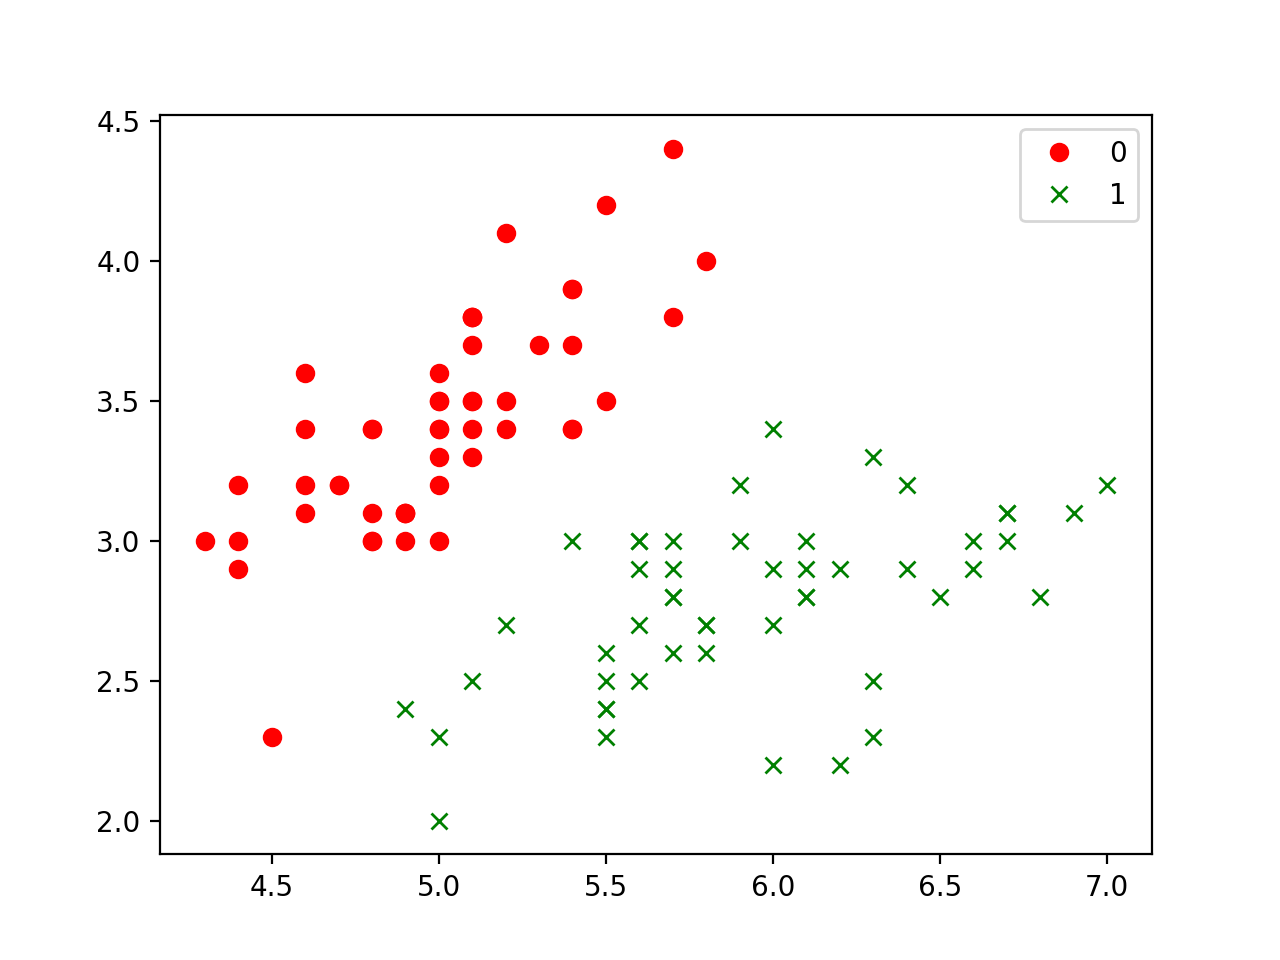

In [2]:
data, labels = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False,
                              setosa=True, versicolor=True, virginica=False)
fig = helpers.scatter2d_multiclass(data, labels)

## 1.1 - A short introduction:

In logistic regression, the probability of a datapoint belonging to a class is found as:
$$P(l_n=1|\xb_n, \wb) = \frac{e^{(\xb_n^T\cdot \wb)}}{1+e^{(\xb_n^T\cdot \wb)}} $$

This is called the sigmoid function! The sigmoid function is defined as:
$$\sigma(t)= \frac {e^t}{1+e^t}= \frac{1}{1+e^{-t}}$$

Let's try to code this function. You can use the numpy function `np.exp(x)` to take the exponential of a number.

In [3]:
def sigmoid(t):
    """ Sigmoid function
    
    Args:
        t (np.array): Input data of shape (N, )
        
    Returns:
        np.array: Probabilites of shape (N, ), where each value is in {0, 1}.
    """
    return 1/(1 + np.exp(-t))

A side note: Since the probabilities sum up to 1, we find $$P(l_n=0|\xb_n, \wb) = 1-P(l_n=1|\xb_n, \wb).$$

**Q: Using $P(l_n|\xb_n, \wb)$ verify the likelihood is equal to:**

$$P(\Lb|\Xb, \wb) = \prod_n\sigma(\xb_n^T\cdot\wb)^{l_n} (1-\sigma(\xb_n^T\cdot\wb))^{1-l_n}  $$

* Hint: You can start from the definition of likelihood: $P(\Lb|\Xb, \wb) = \prod_n P(l_n|\xb_n, \wb)$.

**Q: Using the likelihood, verify that the loss (also called energy) function is equal to:**

$$E(\wb) = -\sum_{n}l_n\log(\sigma(\xb_n^T\cdot \wb))+(1-l_n)\log(1-\sigma(\xb_n^T\cdot \wb))$$

* Hint: Our aim is to maximize the likelihood. This is the same as maximizing the logarithm of the likelihood. This is also the same as minimizing the negative log-likelihood.

This energy function is also equal to:
$$E(\wb) = \sum_{n}(\log(1+e^{\xb_n^T\cdot \wb})-l_n(\xb_n^T\cdot \wb))$$
(Feel free to work this out and see for yourself that they are equal!)

Below we have provided the function for finding the loss, `loss_logistic()`.

In [4]:
def loss_logistic(data, labels, w): 
    """ Logistic regression loss function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        int: Loss of logistic regression.
    """
    return np.sum(np.log(1+np.exp(data.dot(w)))-labels*(data.dot(w)))

We need to find the gradient of the loss function in order to move our weights towards the optimal weights. The gradient of the loss function is:
$$\nabla E(\wb)= \sum_n (\sigma(\xb_n^T\cdot \wb) - l_n)\xb_n^T $$
Let us put this into nice matrix format:
$$\nabla E(\wb)= \Xb^T(\sigma(\Xb\cdot \wb) - \Lb)$$

Fill in the function for finding the gradient `gradient_logistic()`. You can use the numpy function `np.dot()` for matrix multiplication.

In [5]:
def gradient_logistic(data, labels, w):
    """ Logistic regression gradient function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        np. array: Gradient array of shape (D, )
    """
    return np.dot(data.T, sigmoid(np.dot(data, w)) - labels)

## 1.2 - Classifying using a logistic regression model

Now let us write a function to perform classification using logistic regression, `logistic_regression_classify()`. This function uses the weights we find during training in order to predict the labels for the data.

**Hints:**
* We classify our data according to $P(l_n=1|\xb_n, \wb)$. If the value of $P(l_n=1|\xb_n, \wb)$ is less than 0.5 then the data point is classified as label 0. If it is more than 0.5 then we classify the data point as label 1.
* You can do thresholding very easily in numpy. Example: we have an array x that has values {1,1,1,2,2,2,3,3}. We would like to set the values of elements equal to 2 to 0, so we would have {1,1,1,0,0,0,3,3}. We can select the elements of x equal to 2 by `(x==2)`. So we can set these elements to 0 by `x[x==2]=0`.

In [6]:
def logistic_regression_classify(data, w):
    """ Classification function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        np. array: Label assignments of data of shape (N, )
    """
    #### write your code here: find predictions and threshold them.
    predictions = sigmoid(np.dot(data, w))
    predictions[predictions < 0.5] = 0
    predictions[predictions >= 0.5] = 1
    
    return predictions

Let us also use our `accuracy()` function from last week's exercise. Recall that it implements
$$ f_{\text{acc}} = \frac{\text{# correct predictions}}{\text{# all predictions}}$$
We have provided it for you below:

In [7]:
def accuracy(labels_gt, labels_pred):
    """ Computes accuracy.
    
    Args:
        labels_gt (np.array): GT labels of shape (N, ).
        labels_pred (np.array): Predicted labels of shape (N, ).
        
    Returns:
        float: Accuracy, in range [0, 1].
    """
    return np.sum(labels_gt == labels_pred) / labels_gt.shape[0]

## 1.3 - Training a logistic regression model

In order to find good weights and have a high accuracy we need to train our model. Fill in missing parts of the function `logistic_regression_train()`.

The function first initializes the weights according to a gaussian distribution. In each iteration, you should find the gradient using `gradient_logistic` and take a gradient step using these weights. Recall that a gradient step is: $$ \wb^{t + 1}  = \wb^{t} - \eta \nabla E(\wb^{t}) $$

The `loss` and `plot` parameters print out the loss and display the predictions as a plot for the current iteration, respectively. You do not need to modify these parts.


In [8]:
def logistic_regression_train(data, labels, max_iters=10, lr=0.001, loss=True, plot=True):
    """ Training function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        max_iters (integer): Maximum number of iterations. Default:10
        lr (integer): The learning rate of  the gradient step. Default:0.001
        loss (boolean): Calculates the loss of logistic regression at each iteration and prints it. Default:True
        plot (boolean): Plots the predictions at each iteration. Default:True
    Returns:
        np. array: weights of shape(D, )
    """
    #initialize weights randomly according to gaussian distribution
    weights = np.random.normal(0, 0.1, [data.shape[1],])
    for iter in range(max_iters):
        ########## write your code here: find gradient and do a gradient step
        gradient = gradient_logistic(data, labels, weights)
        weights = weights - lr * gradient
        ##################################
        predictions = logistic_regression_classify(data, weights)
        if loss:
            print('loss at iteration', iter, ":", loss_logistic(data, labels, weights))
        if plot:
            fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions)
            plt.title("iteration "+ str(iter))
        if accuracy(labels, predictions) == 1:
            break
    return weights

Run the code below to see your training in action. What do you observe? Try playing with the learning rate and number of max iterations.

In [9]:
weights = logistic_regression_train(data, labels, max_iters=25, lr=0.001, loss=True, plot=False)

loss at iteration 0 : 69.36906639406375
loss at iteration 1 : 68.718447728611
loss at iteration 2 : 68.07842905000975
loss at iteration 3 : 67.44858175602732
loss at iteration 4 : 66.82874058742965
loss at iteration 5 : 66.21874138303957
loss at iteration 6 : 65.61842116956285
loss at iteration 7 : 65.02761825802537
loss at iteration 8 : 64.44617233376167
loss at iteration 9 : 63.873924540061246
loss at iteration 10 : 63.3107175556151
loss at iteration 11 : 62.756395665917104
loss at iteration 12 : 62.21080482878765
loss at iteration 13 : 61.6737927341968
loss at iteration 14 : 61.14520885857227
loss at iteration 15 : 60.624904513785204
loss at iteration 16 : 60.11273289101152
loss at iteration 17 : 59.60854909967086
loss at iteration 18 : 59.112210201647954
loss at iteration 19 : 58.62357524100295
loss at iteration 20 : 58.1425052693774
loss at iteration 21 : 57.66886336730252
loss at iteration 22 : 57.202514661614586
loss at iteration 23 : 56.74332633918062
loss at iteration 24 : 56.

In [10]:
predictions = logistic_regression_classify(data, weights)
print("Accuracy is", accuracy(labels, predictions))

Accuracy is 0.99


Now that we have classified two classes, we can move on to multi-class logistic regression.

# 2. Multi-Class Logistic Regression

Load the synthetic data by running the code segment below. We will use this dataset for now as it is easy to work with.
Our data is:

 - data: $\Xb \in \real^{N \times 2}$, $\forall \xb_n \in \Xb: \xb_n \in \real^{2}$
 - labels: $\Lb \in \real^{N}$, $\forall l_n \in \Lb: l_n \in \{0, 1, 2\}$ 

<IPython.core.display.Javascript object>


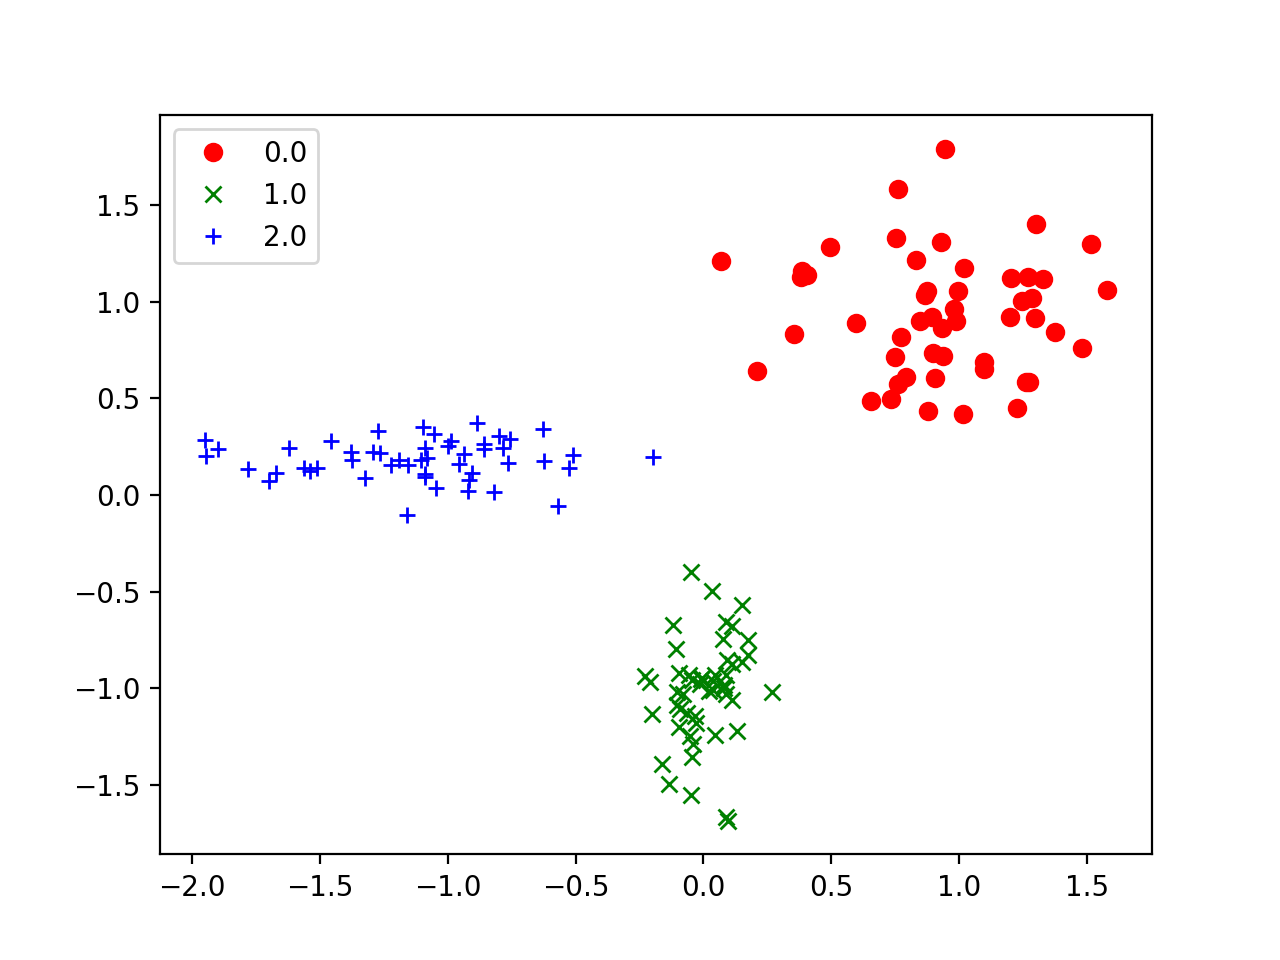

In [11]:
data_multi, labels_multi = helpers.load_dataset_synth()
fig = helpers.scatter2d_multiclass(data_multi, labels_multi, fig=None, fig_size=None, color_map=None,
                         legend=True, legend_map=None, grid=False, show=False)

## 2.1 - A short introduction 

Multi class logistic regression is an extention to binary logistic regression.

Let us consider logistic regression for K classes. We keep our weights in a weight matrix $\mathbf{W}$, where every column is $\wb_k$ for class $k$. Therefore, for every class $k$, we learn a separate $\wb_k$ during training. The weights matrix will be of size $(D \times K)$.

The generalized probabilities for logistic regression is
$$P(l_n=k|\xb_n, \mathbf{W}) = \frac{e^{\xb_n^T\cdot \wb_k}}{\sum_j^K e^{\xb_n^T\cdot \wb_j}}$$ 
which is called the softmax function! Let us denote this function by $f_\text{softmax}$.

Study the implementation of this function below. It is used to assign the probabilities of a datapoint belonging to each class. For example, for a single datapoint, for 3 classes you might have the following probability assignments {0.2, 0.7, 0.1}. The probabilities all sum up to 1. 


In [12]:
def f_softmax(data, w):
    """ Softmax function
    
    Args:
        data (np.array): Input data of shape (N, D)
        w (np.array): Weights of shape (D, K) where K is # of classes
        
    Returns:
        np.array: Probabilites of shape (N, D), where each value is in {0, 1} and each row sums to 1.
    """
    
    #data.shape[0] is the number of datapoints, and w.shape[1] is the number of classes.
    res = np.zeros([data.shape[0], w.shape[1]]) 
    #The normalization term only has to be calculated once for all classes
    norm = np.sum(np.exp(np.dot(data,w)), axis=1)
    #We iterate for each class
    for k in range(w.shape[1]):
        exp_top = np.exp(np.dot(data,w[:, k]))
        res[:, k] = exp_top/norm
    return res

Using these, we find the loss function which we are trying to minimize is

$$E(\mathbf{W}) = -\sum_{n}\sum_{k}\mathbb{1}_{[l_n=k]}\log(f_\text{softmax}(\xb_{n}^T \cdot \wb_k))$$ 

The expression $\mathbb{1}_{[l_n=k]}$ is the indicator function, meaning that it is 1 when the label is equal to $k$. The loss function code is provided for you below. Note the use of `(labels==k)` for the indicator function $\mathbb{1}_{[l_n=k]}$.

In [13]:
def loss_logistic_multi(data, labels, w):
    """ Loss function for multi class logistic regression
    
    Args:
        data (np.array): Input data of shape (N, D)
        labels (np.array): Labels of shape  (N, )
        w (np.array): Weights of shape (D, K)
        
    Returns:
        int: Loss value 
    """
    
    loss =  0
    res = f_softmax(data, w)
    for k in range(w.shape[1]):
        loss -= np.sum((labels==k)*np.log(res[:,k]))
    return loss

To find the gradient, we find the gradient of $E(\mathbf{W})$ with respect to each $\wb_k$ vector separately. For model $\wb_k$ we have
$$\nabla E(\mathbf{W})_{\wb_k}=\sum_n(f_\text{softmax}(\xb_{n}^T \cdot \wb_k)-\mathbb1_{[l_n=k]})\xb_{n}^T$$
Let's put this into matrix format as well:
$$\nabla E(\mathbf{W})_{\wb_k}= \Xb^T(f_\text{softmax}(\Xb\cdot \wb_k) - \mathbf{1}_{[l = k]})$$

Now, you will fill in the gradient function, `gradient_logistic_multi()` given below. 

Hints: 
* You can refer to the loss function implemented above as a guideline (follow a similar format)

In [14]:
def gradient_logistic_multi(data, labels, w):
    """ Gradient function for multi class logistic regression
    
    Args:
        data (np.array): Input data of shape (N, D)
        labels (np.array): Labels of shape  (N, )
        w (np.array): Weights of shape (D, K)
        
    Returns:
        int: Loss value 
    """
    grad_w = np.zeros(w.shape)
    #Write your code here to fill in grad_w correctly
    
    fsmax = f_softmax(data, w)
    
    for i in range(w.shape[1]):
        grad_w[:, i] = np.dot(data.T, fsmax[:, i] - (labels == i))
    
    return grad_w

## 2.2 - Classification and training for multiple classes

Write the functions for classification and training.

Hints:
* For the classification function, you will be using $f_\text{softmax}$ to assign the probabilities of a datapoint belonging to each class. The softmax function returns an array of size $(N \times K)$.
* To find which class a point is assigned to use the numpy function `argmax`. This function returns the index of the highest value in an array. This function has an argument `axis` which you should set to 1. 

* Training will be the same as the binary case. First, we will find the gradient. Then we will update the weights using gradient descent.

In [15]:
def logistic_regression_classify_multi(data, w):
    """ Classification function for multi class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        w (np.array): Weights of logistic regression model of shape (D, K)
    Returns:
        np. array: Label assignments of data of shape (N, ).
    """
    #### write your code here: find predictions, argmax to find the correct label
    predictions = f_softmax(data, w)
    return np.argmax(predictions, axis=1)

In [16]:
def logistic_regression_train_multi(data, labels, k=3, max_iters=10, lr=0.001, loss=True, plot=True):
    """ Classification function for multi class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, )
        k (integer): Number of classes. Default=3
        max_iters (integer): Maximum number of iterations. Default:10
        lr (integer): The learning rate of  the gradient step. Default:0.001
        loss (boolean): Calculates the loss of logistic regression at each iteration and prints it. Default:True
        plot (boolean): Plots the predictions at each iteration. Default:True
    Returns:
        np. array: Label assignments of data of shape (N, ).
    """
    weights = np.random.normal(0, 0.1, [data.shape[1], k])
    for iter in range(max_iters):
        gradient = gradient_logistic_multi(data, labels, weights)
        weights = weights - lr * gradient
        ##################################
        predictions = logistic_regression_classify_multi(data, weights)
        if loss:
            print('loss at iteration', iter, ":", loss_logistic_multi(data, labels, weights))
        if plot:
            fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions)
            plt.title("iteration "+ str(iter))
        if accuracy(labels, predictions) == 1:
            break
    return weights

In [17]:
weights_multi = logistic_regression_train_multi(data_multi, labels_multi, max_iters=15, lr=5e-4, loss=True, plot=False)

loss at iteration 0 : 154.39896647747622
loss at iteration 1 : 149.94006713331405
loss at iteration 2 : 145.66381207129047
loss at iteration 3 : 141.56355524854575


In [18]:
predictions_multi = logistic_regression_classify_multi(data_multi, weights_multi)
print("Accuracy is", accuracy(labels_multi, predictions_multi))

Accuracy is 1.0


**A side note:** Notice that using this simple formulation, we have trained K classifiers for K classes.
Our probability assignments are according to the softmax function.
$$P(l_n=k|\xb_n, \mathbf{W}) = \frac{e^{\xb_n^T\cdot \wb_k}}{\sum_j^K e^{\xb_n^T\cdot \wb_j}}$$
And $$\sum_{k}^{K}P(l_n=k|\xb_n, \mathbf{W})=1$$
However, in the binary case we were training 1 classifier for 2 classes. The probabilities are assigned according to the sigmoid function.
$$P(l_n=1|\xb_n, \wb) = \frac{e^{(\xb_n^T\cdot \wb)}}{1+e^{(\xb_n^T\cdot \wb)}} \\
P(l_n=0|\xb_n, \wb) = 1-P(l_n=1|\xb_n, \wb) = \frac{1}{1+e^{(\xb_n^T\cdot \wb)}}$$

Similar to the binary case, we can train K-1 classifiers for K classes. We modify the probability assignment function to be, for classes $k={1, ... ,K-1}$.
$$P(l_n=k|\xb_n, \mathbf{W}) = \frac{e^{\xb_n^T\cdot \wb_k}}{1+\sum_j^{K-1} e^{\xb_n^T\cdot \wb_j}}$$

**Q: What is $P(l_n=K|\xb_n, \mathbf{W})$?**

Further reading: https://en.wikipedia.org/wiki/Multinomial_logistic_regression

## 2.3 Test on the Iris dataset:

Now let us  test our code on the iris dataset. We load and display the dataset below. 

<IPython.core.display.Javascript object>


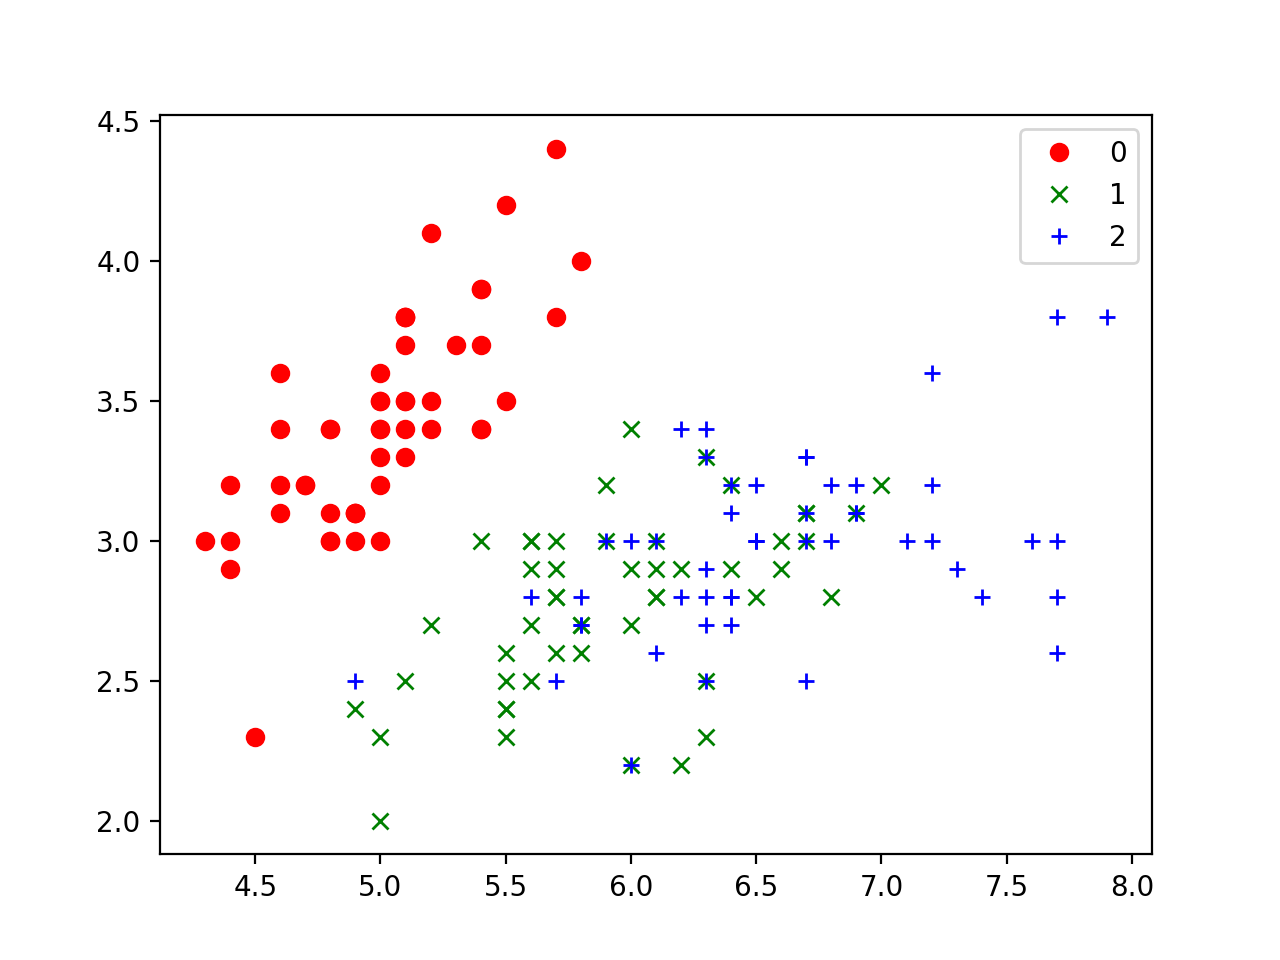

In [19]:
data_multi, labels_multi = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False, setosa=True, versicolor=True, virginica=True)
fig = helpers.scatter2d_multiclass(data_multi, labels_multi, fig=None, fig_size=None, color_map=None,
                         legend=True, legend_map=None, grid=False, show=False)

In [20]:
weights_multi = logistic_regression_train_multi(data_multi, labels_multi, max_iters=100, lr=1e-3, loss=True, plot=False)
predictions_multi = logistic_regression_classify_multi(data_multi, weights_multi)
print("Accuracy is", accuracy(labels_multi, predictions_multi))

loss at iteration 0 : 169.57451451780224
loss at iteration 1 : 169.39468527170368
loss at iteration 2 : 175.07497798080652
loss at iteration 3 : 171.25006540497984
loss at iteration 4 : 177.91126577034493
loss at iteration 5 : 170.02679743170626
loss at iteration 6 : 176.43804821735898
loss at iteration 7 : 167.63964275101992
loss at iteration 8 : 173.64558664321999
loss at iteration 9 : 165.22656965291398
loss at iteration 10 : 170.78350414869286
loss at iteration 11 : 162.96461368925068
loss at iteration 12 : 168.03196703630334
loss at iteration 13 : 160.86143009984576
loss at iteration 14 : 165.4105712935303
loss at iteration 15 : 158.903199513286
loss at iteration 16 : 162.9211350312376
loss at iteration 17 : 157.07403855419267
loss at iteration 18 : 160.56286118550366
loss at iteration 19 : 155.35929260197696
loss at iteration 20 : 158.3335743837123
loss at iteration 21 : 153.74634494482152
loss at iteration 22 : 156.22975618782795
loss at iteration 23 : 152.22468975259687
loss at

<IPython.core.display.Javascript object>


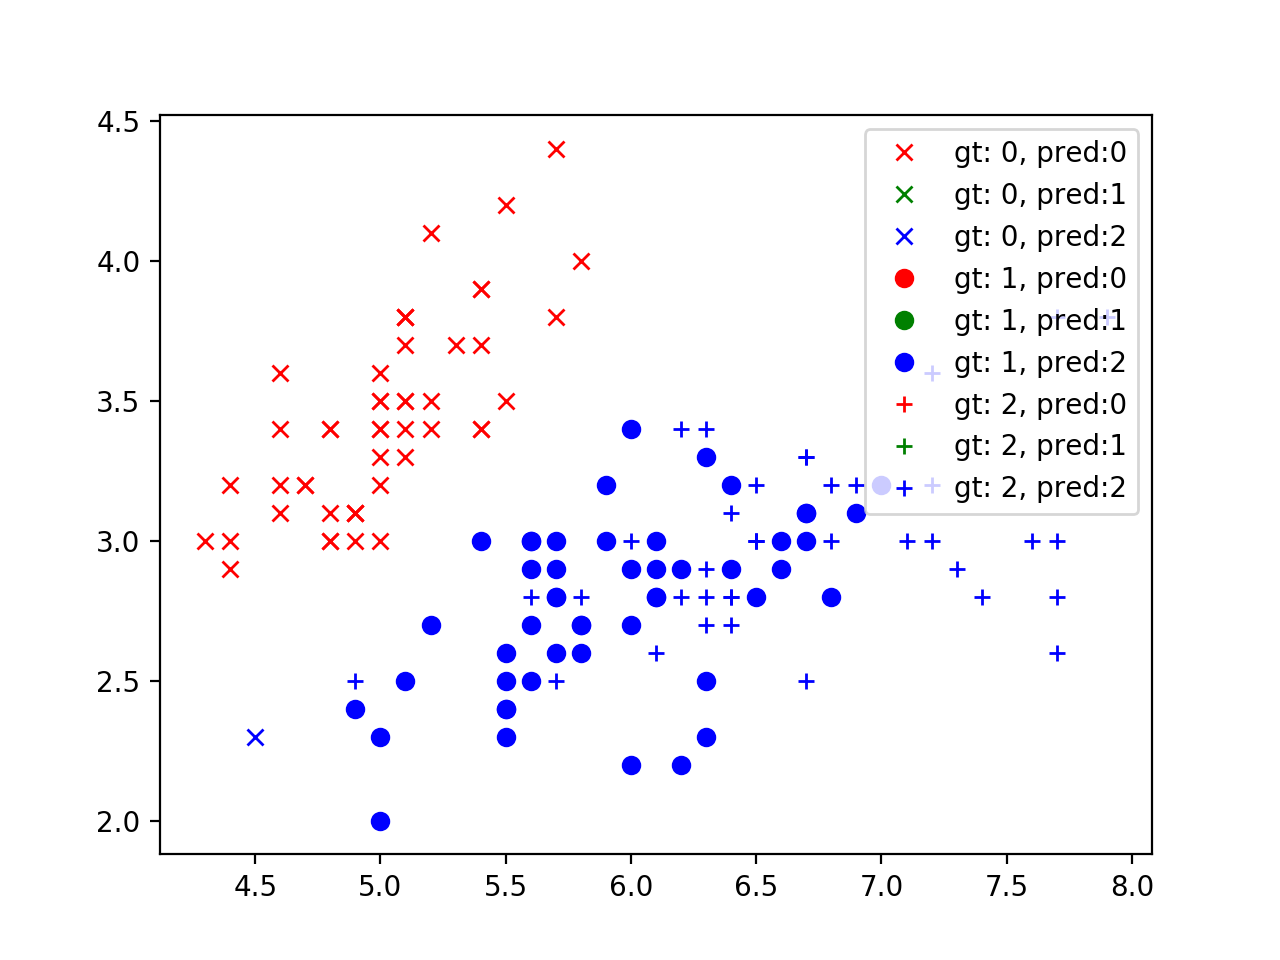

In [21]:
fig = helpers.visualize_predictions(data=data_multi, labels_gt=labels_multi, labels_pred=predictions_multi)

 **Q: Comment on the accuracy. What is the difference between the synthetic dataset and this one?**